<a href="https://colab.research.google.com/github/natalied0000/Stock-Value-Prediction-with-LSTM/blob/main/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Basic Stats**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import time
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score
from scipy.stats import linregress
from sklearn.metrics import max_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df_lstm = pd.read_csv('/content/TWTR (1).csv', index_col='Date')
df_lstm.Date=[dt.datetime.strptime(d, '%Y-%m-%d').date() for d in df_lstm.index.values]

df_lstm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,28.260000,28.990000,27.870001,28.809999,28.809999,15053700
2019-01-03,28.379999,29.180000,27.940001,27.990000,27.990000,19051700
2019-01-04,28.389999,30.100000,28.309999,29.950001,29.950001,23412600
2019-01-07,30.200001,31.379999,29.770000,31.340000,31.340000,19917800
2019-01-08,31.700001,32.049999,30.910000,31.799999,31.799999,18915200


In [4]:
df_lstm.shape

(863, 6)

In [5]:
df_lstm.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-27,39.570000,40.770000,39.480000,40.169998,40.169998,16789900
2022-05-31,40.070000,40.349998,39.419998,39.599998,39.599998,11579000
2022-06-01,39.799999,40.259998,39.240002,39.299999,39.299999,11117200
2022-06-02,39.070000,40.470001,38.810001,39.910000,39.910000,11696000
2022-06-03,40.450001,41.040001,39.980000,40.160000,40.160000,18244400


In [6]:
df_lstm.describe()

,Open,High,Low,Close,Adj Close,Volume
count,863.000000,863.000000,863.000000,863.000000,863.000000,8.630000e+02
mean,43.745226,44.538007,42.935736,43.718459,43.718459,2.000770e+07
std,12.717354,12.917236,12.463546,12.665124,12.665124,2.167192e+07
min,22.110001,23.490000,20.000000,22.000000,22.000000,3.661100e+06
25%,33.815000,34.524999,33.295000,33.990000,33.990000,1.102260e+07
50%,39.790001,40.439999,39.250000,39.779999,39.779999,1.524290e+07
75%,51.995001,52.855000,50.575001,51.895000,51.895000,2.115005e+07
max,78.360001,80.750000,76.050003,77.629997,77.629997,2.684654e+08


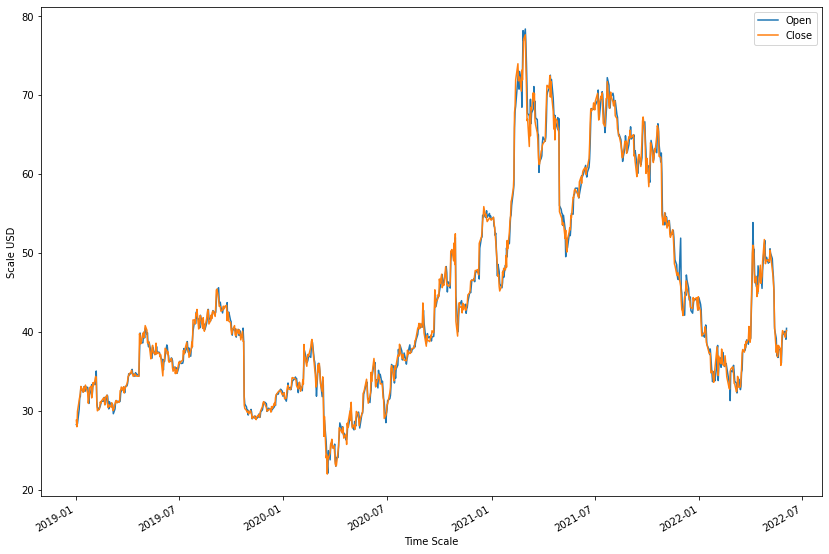

In [7]:
plt.rcParams['figure.figsize']=(14,10)
x=[dt.datetime.strptime(d, '%Y-%m-%d').date() for d in df_lstm.index.values]
plt.plot(x, df_lstm['Open'], label='Open')
plt.plot(x,df_lstm['Close'], label='Close')

plt.xlabel('Time Scale')
plt.ylabel('Scale USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

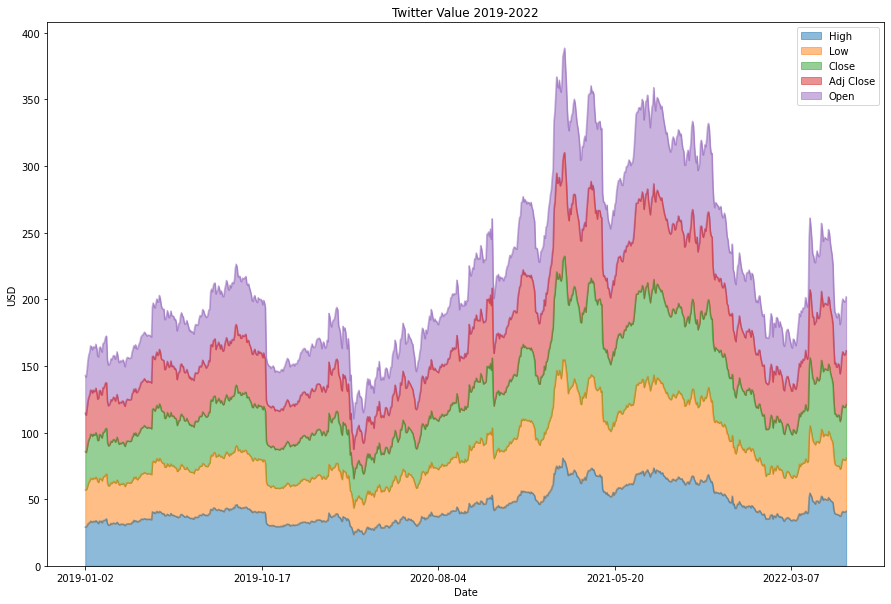

In [8]:
df_lstm[["High","Low","Close","Adj Close","Open"]].plot.area(figsize=(15,10),alpha=0.5);
plt.title('Twitter Value 2019-2022')
plt.ylabel("USD")
plt.xlabel('Date')
plt.show()

In [9]:
df_lstm.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Linear Regression


In [10]:
df_linreg = pd.read_csv('/content/TWTR (1).csv')

reg = LinearRegression(copy_X=True, fit_intercept=True)
df_linreg['Time'] = np.arange(len(df_linreg.index))
X = df_linreg.loc[:, ['Time']]  # features
y = df_linreg.loc[:, 'Close']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

reg.fit(X_train, y_train)
X_train.shape

(690, 1)

In [14]:
y_pred = reg.predict(X_test)

In [15]:
linregress(y_test,y_pred)

LinregressResult(slope=0.3026908306124756, intercept=30.72965754027246, rvalue=0.5356228473322515, pvalue=3.1239404215135377e-14, stderr=0.03649386160463062)

In [16]:
reg_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Date value': X_test.values.flatten(), 'Diference': y_test-y_pred})
reg_res.sort_values(by=['Date value'], inplace=True)
reg_res

,Actual,Predicted,Date value,Diference
3,31.340000,31.898129,3,-0.558129
8,32.369999,32.036357,8,0.333642
16,32.900002,32.257522,16,0.642480
17,33.130001,32.285167,17,0.844834
19,32.259998,32.340458,19,-0.080460
...,...,...,...,...
841,49.060001,55.065105,841,-6.005104
843,49.799999,55.120396,843,-5.320397
849,37.389999,55.286269,849,-17.896270
854,37.860001,55.424497,854,-17.564496


In [17]:
max_error(y_test, y_pred)

30.80326774007021

In [18]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
MSE = np.square(np.subtract(y_test,y_pred)).mean()
print(MSE)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test,y_pred)
print(r2)

Mean Absolute Error: 8.287905132426618
111.03962448187168
Mean Squared Error: 111.03962448187171
Root Mean Squared Error: 10.537534079749005
0.28599887172760363


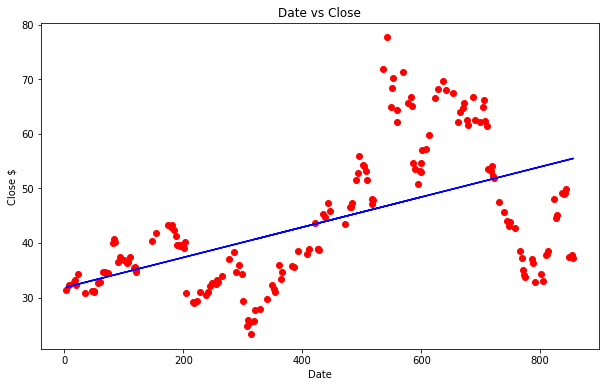

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='red')
plt.plot(X_test, y_pred, color='blue')
plt.title('Date vs Close')
plt.xlabel('Date')
plt.ylabel('Close $')
plt.show()

Text(0, 0.5, 'Amount of errors in sample')

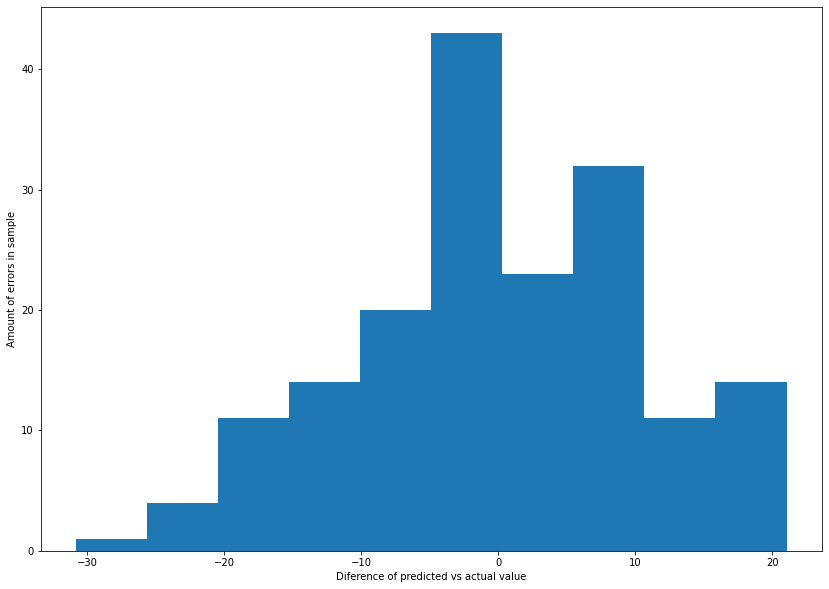

In [20]:
residuals = y_pred - y_test
plt.hist(residuals)
plt.xlabel("Diference of predicted vs actual value")
plt.ylabel("Amount of errors in sample")

# **LSTM**

In [21]:
data = df_lstm.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 )-1)

sc = StandardScaler()

scaled_data = sc.fit_transform(dataset)
training_data_len

690

In [22]:
train_data = scaled_data[0:int(training_data_len), :]
X_train2=[]
y_train2=[]
for i in range(60,len(train_data)):
    X_train2.append(train_data[i-60:i,0])
    y_train2.append(train_data[i,0])

X_train2= np.array(X_train2)
y_train2=np.array(y_train2)    

X_train2=X_train2.reshape((len(train_data)-60),60,1)

X_train2.shape

(630, 60, 1)

In [23]:
lstm = Sequential()
lstm.add(LSTM(64, return_sequences=True, input_shape= (X_train2.shape[1], 1)))
lstm.add(LSTM(32, return_sequences=False))
lstm.add(Dense(25))
lstm.add(Dense(1))

#Compiling RNN
lstm.compile(optimizer='adam',loss='mean_squared_error')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 25)                825       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 30,163
Trainable params: 30,163
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm.fit(X_train2,y_train2,epochs=10,batch_size=32)

Epoch 1/10
20/20 [==============================] - 5s 60ms/step - loss: 0.2733
Epoch 2/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0802
Epoch 3/10
20/20 [==============================] - 1s 59ms/step - loss: 0.0627
Epoch 4/10
20/20 [==============================] - 2s 99ms/step - loss: 0.0513
Epoch 5/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0461
Epoch 6/10
20/20 [==============================] - 1s 63ms/step - loss: 0.0410
Epoch 7/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0373
Epoch 8/10
20/20 [==============================] - 1s 59ms/step - loss: 0.0357
Epoch 9/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0329
Epoch 10/10
20/20 [==============================] - 1s 60ms/step - loss: 0.0337


In [25]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
X_test2 = []
y_test2 = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test2.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
X_test2 = np.array(X_test2)

# Reshape the data
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1 ))

# Get the models predicted price values 
y_pred2 = lstm.predict(X_test2)
y_pred2  = sc.inverse_transform(y_pred2 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


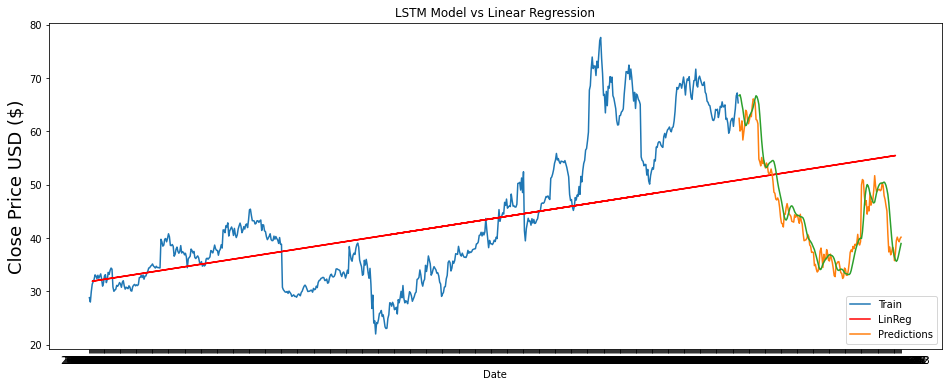

In [26]:
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = y_pred2
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model vs Linear Regression')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(X_test, y_pred, color='red')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'LinReg', 'Predictions'], loc='lower right')

plt.show()

In [27]:
df3 = pd.DataFrame({'Actual': y_test2.flatten() , 'Predicted (Linear)': y_pred, 'Predicted (LSTM)': y_pred2.flatten(),'Date-Index':X_test.values.flatten(), 'Diference(Linear)':y_test-y_pred,'Diference(LSTM)': (y_test2-y_pred2).flatten()})
df3.sort_values(by=['Date-Index'], inplace=True)
df3

,Actual,Predicted (Linear),Predicted (LSTM),Date-Index,Diference(Linear),Diference(LSTM)
3,63.680000,31.898129,61.282112,3,-0.558129,2.397888
8,55.110001,32.036357,58.217358,8,0.333642,-3.107357
16,45.849998,32.257522,49.806583,16,0.642480,-3.956585
17,46.459999,32.285167,43.679436,17,0.844834,2.780563
19,34.169998,32.340458,36.535011,19,-0.080460,-2.365013
...,...,...,...,...,...,...
841,39.299999,55.065105,37.317524,841,-6.005104,1.982475
843,45.080002,55.120396,49.132404,843,-5.320397,-4.052402
849,52.330002,55.286269,53.763657,849,-17.896270,-1.433655
854,38.700001,55.424497,39.585991,854,-17.564496,-0.885990


In [28]:
lstm_maxErr= max_error(y_test2, y_pred2)
lstm_maxErr

10.254299537109375

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test2, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test2, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))
r2 = r2_score(y_test2,y_pred2)
print(r2)

Mean Absolute Error: 2.2589370614923907
Mean Squared Error: 9.477504922825334
Root Mean Squared Error: 3.078555655307426
0.8791056901934395
